###  Building a Binary Classifier with Kepler Exoplanet Data
#### Mahdi Boulila - https://medium.com/@mahdi8boulila


## Data Preparation

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
df = pd.read_csv('cumulative.csv')

In [71]:
df

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10031643,K07984.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,...,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

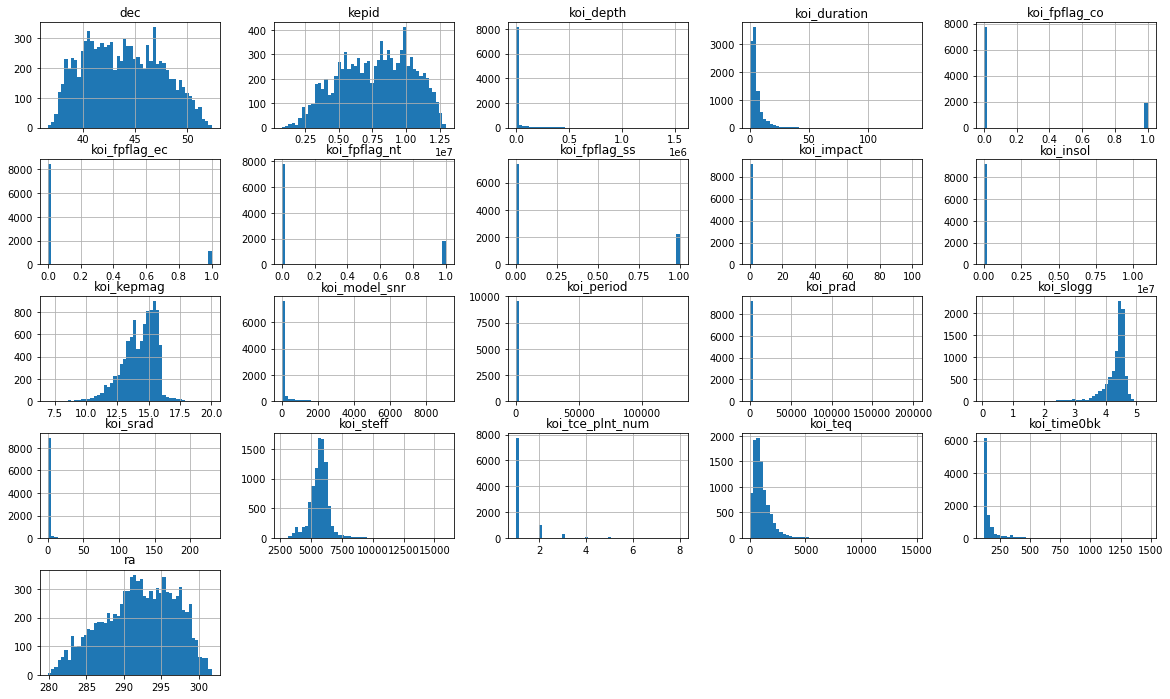

In [73]:
# We can see that there are a lot of columns with NaN values.
# let's take care of all columns that we do not need
drop_list = ["kepler_name","rowid","kepoi_name","koi_score"]
for col in df:
    if 'err' in col:
        drop_list.append(col)
df = df.drop(drop_list, axis=1)
# plotting histograms
df.hist(bins=50, figsize=(20,12))
plt.show()

In [74]:
df.koi_disposition.value_counts()

FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64

In [75]:
df.koi_pdisposition.value_counts()

FALSE POSITIVE    5068
CANDIDATE         4496
Name: koi_pdisposition, dtype: int64

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Getting all categorical values in our dataframe
import numpy as np
df1 = df.drop("koi_disposition", axis = 1)
cat_attribs = []
for label in df1:
    if (df1[label].dtype != np.number) and (df1[label].dtype != "int64"):
        cat_attribs += [label]
        
# getting numerical values  
num_attribs = df.select_dtypes(include=['int64', 'float64']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=float("NaN"),strategy="mean")),
    ('scaler', StandardScaler()),])
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])

## Splitting training and testing set + Training our MLA

In [77]:
# splitting the traning and testing set , dropping the labels!
from sklearn.model_selection import train_test_split

df.koi_disposition = (df.koi_disposition == "CONFIRMED") # since it is a binary classifier

x_train, x_test, y_train, y_test = train_test_split(df.drop("koi_disposition", axis=1),df.koi_disposition, test_size=0.2, random_state=42)
x_train

,kepid,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
9132,5097470,FALSE POSITIVE,0,1,1,1,1.288058,131.991400,0.214,3.4190,...,2142.23,28.1,1.0,q1_q17_dr25_tce,5631.0,4.330,1.132,291.25308,40.216671,14.487
2991,8822216,CANDIDATE,0,0,0,0,151.863949,143.314510,0.016,8.5770,...,2.43,22.5,2.0,q1_q17_dr25_tce,5713.0,4.541,0.893,293.17133,45.065601,14.807
4141,2831251,FALSE POSITIVE,0,0,1,0,5.812898,131.561300,0.499,3.9790,...,348.61,9.5,1.0,q1_q17_dr25_tce,6175.0,4.410,1.041,285.56747,38.040691,14.510
8636,10843203,FALSE POSITIVE,0,1,0,0,4.429633,355.143546,1.264,3.0257,...,192.62,166.3,1.0,q1_q17_dr25_tce,5344.0,4.545,0.809,282.23273,48.271198,15.910
1382,10019708,FALSE POSITIVE,0,1,1,0,8.784583,135.378120,0.681,6.4590,...,411.55,25.9,2.0,q1_q17_dr25_tce,5927.0,4.046,1.691,295.02567,46.956001,14.879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,5905728,FALSE POSITIVE,0,0,1,0,7.871737,132.354050,0.001,2.6190,...,130.96,10.8,1.0,q1_q17_dr25_tce,5428.0,4.404,0.940,299.14111,41.185001,11.237
5472,9957351,FALSE POSITIVE,1,0,0,0,0.991105,131.893383,0.623,2.2137,...,589.31,273.8,1.0,q1_q17_dr25_tce,4769.0,4.673,0.578,294.35410,46.840851,16.948
5688,5110423,FALSE POSITIVE,0,1,0,0,2.685224,133.731821,1.280,4.0632,...,360.92,238.7,1.0,q1_q17_dr25_tce,5552.0,4.620,0.719,294.83679,40.265598,15.828
898,8874090,CANDIDATE,0,0,0,0,13.323894,135.245850,0.073,3.2208,...,4.83,25.9,1.0,q1_q17_dr25_tce,3751.0,4.813,0.450,287.05453,45.180370,15.931


In [79]:
x_train_prepared = full_pipeline.fit_transform(x_train)

In [80]:
x_train_prepared.shape

(7156, 26)

In [81]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train_prepared,y_train)

SGDClassifier(random_state=42)

## First Evaluation

In [112]:
from sklearn.model_selection import cross_val_score, cross_val_predict
y_scores = cross_val_predict(sgd_clf, x_train_prepared, y_train, cv=3, method="decision_function")
y_scores

array([ -5.73156223,  -0.11236523,  -3.27764577, ...,  -3.95637563,
         0.74869266, -15.33362906])

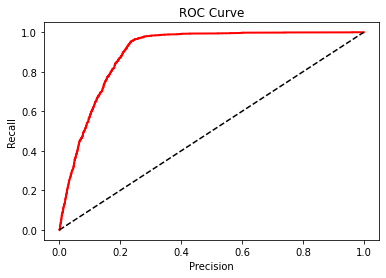

In [142]:
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds1 = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, c='r')
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.title("ROC Curve")
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    # Add axis labels and grid
plot_roc_curve(fpr1, tpr1)
plt.show()

In [122]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve
x_test_prepared = full_pipeline.fit_transform(x_test)
y_test_pred = sgd_clf.predict(x_test_prepared)

In [123]:
precision_score(y_test, y_test_pred,average='weighted')

0.8486954134065325

In [124]:
recall_score(y_test, y_test_pred,average='weighted') 

0.8323085522638345

In [125]:
f1_score(y_test, y_test_pred,average='weighted')

0.8374103834630933

In [126]:
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[1122,  203],
       [  97,  367]], dtype=int64)

## Fine-Tuning the MLA

In [134]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'loss': ["hinge","log","perceptron"], 'alpha': [0.1,0.01,1e-3, 1e-6, 1e-9]},
]
sgd_2 = SGDClassifier(random_state=42)
grid_search = GridSearchCV(sgd_2, param_grid, cv=5,return_train_score=True)
grid_search.fit(x_train_prepared, y_train)
grid_search.best_estimator_

SGDClassifier(alpha=0.001, loss='log', random_state=42)

In [138]:
y_test_pred_sgd_2 = grid_search.predict(x_test_prepared)
precision_score(y_test, y_test_pred_sgd_2,average='weighted')

0.8471161271988497

In [139]:
recall_score(y_test, y_test_pred_sgd_2,average='weighted') 

0.8283957518166574

In [140]:
f1_score(y_test, y_test_pred_sgd_2,average='weighted')

0.834039080583486

In [144]:
y_scores = cross_val_predict(grid_search, x_train_prepared, y_train, cv=5, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

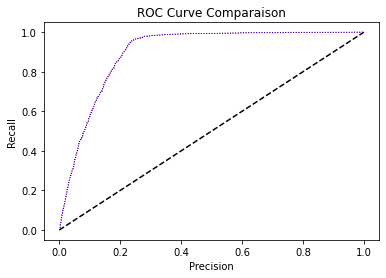

In [161]:
# comparing the old roc with the new one.
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
plt.title("ROC Curve Comparaison")
plt.ylabel("Recall")
plt.xlabel("Precision")
plt.plot(fpr, tpr,':', linewidth=1, label=label, c='r')
plt.plot(fpr1, tpr1,':', linewidth=1, label=label, c='b')
plt.show()
# Basically the same ROC Curve